In [1]:
# Import necessary libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import dowhy
from dowhy import CausalModel
import re
from collections import Counter



def load_data(filepath):
    df = pd.read_csv(filepath, header=None, skiprows=0)
    df.columns = df.iloc[0]
    df = df[1:]
    return df



# Load and preprocess data
file_path = r"C:\Users\nstep\TSU\SeniorProject\nashvilleDF.csv"
nashvilleDF = load_data(file_path)

#nashvilleDf to lower case

nashvilleDF.head()

#check to see if nashvilleDF has a column named 'id' and show results for 5 rows
nashvilleDF['id'].head()

C:\Users\nstep\AppData\Local\Temp\ipykernel_8420\596880472.py:21: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244) have mixed types. Specify dtype option on impor

1      6422
2     39870
3     72906
4    258817
5    289242
Name: id, dtype: object

In [2]:
# Filter rows where 'wifi' column equals 1
wifi_1_rows = nashvilleDF[nashvilleDF['wifi'] == 1]

# Calculate the percentage
percent_with_wifi_1 = (len(wifi_1_rows) / len(nashvilleDF)) * 100

print(f"Percentage of rows with 'wifi' = 1 in nashvilleDF: {percent_with_wifi_1:.2f}%")


# Filter rows where 'wifi' column equals 1
resort_1_rows = nashvilleDF[nashvilleDF['resort access'] == 1]

# Calculate the percentage
percent_with_resort_1 = (len(resort_1_rows) / len(nashvilleDF)) * 100

print(f"Percentage of rows with 'wifi' = 1 in nashvilleDF: {percent_with_resort_1:.2f}%")

Percentage of rows with 'wifi' = 1 in nashvilleDF: 51.36%
Percentage of rows with 'wifi' = 1 in nashvilleDF: 2.66%


In [3]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, KFold
from joblib import Parallel, delayed
import numpy as np

def process_fold(fold, train_index, test_index, X, y):
    model = HistGradientBoostingRegressor()
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    sorted_idx = perm_importance.importances_mean.argsort()[::-1]
    sorted_features = [(X.columns[i], perm_importance.importances_mean[i]) for i in sorted_idx]
    return score, perm_importance.importances_mean, sorted_features

# Assuming nashvilleDF is defined
X = nashvilleDF.drop(['price', 'id'], axis=1)
y = nashvilleDF['price']
X.columns = X.columns.astype(str)

num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
scores = np.zeros(num_folds)
feature_importances = np.zeros((num_folds, X.shape[1]))
results = Parallel(n_jobs=-1)(delayed(process_fold)(fold, train_index, test_index, X, y) 
                              for fold, (train_index, test_index) in enumerate(kf.split(X)))

accuracy_scores = []
for fold, (score, importance, sorted_features) in enumerate(results):
    scores[fold] = score
    feature_importances[fold] = importance
    
    # Append the score to accuracy_scores list
    accuracy_scores.append(score)

    print(f'Fold {fold+1}: Accuracy = {scores[fold]}')
    print("Features ranked by importance for fold:", fold+1)
    for name, imp in sorted_features:
        print(f"{name}: {imp}")

# Compute and print the average accuracy and standard deviation across all folds
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
print(f'Average Accuracy: {mean_accuracy}')
print(f'Standard Deviation of Accuracy: {std_accuracy}')

# Compute the average feature importance across all folds
avg_feature_importances = feature_importances.mean(axis=0)

# Get the top 20 features based on average importance
top_features = np.argsort(avg_feature_importances)[-20:]
top_feature_names = X.columns[top_features]
top_feature_importances = avg_feature_importances[top_features]

print("Top 20 Features and their Importances:")
print(list(zip(top_feature_names, top_feature_importances)))


Fold 1: Accuracy = 0.7485914917853169
Features ranked by importance for fold: 1
accommodates: 0.3249443391125023
bathrooms: 0.1673657389394899
neighbourhood_cleansed_num: 0.0897951701182395
minimum_minimum_nights: 0.046354702604967435
bedrooms: 0.034686143465904005
reviews_per_month: 0.02783197874793284
availability_30: 0.02041611449079399
minimum_maximum_nights: 0.014295058706322994
review_scores_location: 0.013604157577681297
beds: 0.013196739488652576
pool: 0.012635831427142686
maximum_nights: 0.010773937075829465
number_of_reviews: 0.009850177199668474
host_acceptance_rate: 0.009229900821650016
resort access: 0.008552053437020136
free parking: 0.008146420825081779
review_scores_rating: 0.007035840693390705
elevator: 0.005909955131714983
host_is_superhost: 0.005222612053125164
fireplace: 0.004666017648390664
private entrance: 0.0044401972357485334
fire extinguisher: 0.004335293825643072
prop_Entire home: 0.0042254574256188615
books and reading material: 0.0032603705877155
host_respo

accommodates: 9.0
bathrooms: 8.0
neighbourhood_cleansed_num: 7.0
minimum_minimum_nights: 6.0
bedrooms: 5.0
reviews_per_month: 4.0
availability_30: 3.0
minimum_maximum_nights: 2.0
beds: -1.0
pool: -1.0
review_scores_location: -1.0
maximum_nights: -2.0
number_of_reviews: -3.0
resort access: -5.0
host_acceptance_rate: -5.0
review_scores_rating: -8.0
free parking: -9.0
elevator: -12.0
host_is_superhost: -16.0
fireplace: -18.0
availability_365: -25.0
maximum_maximum_nights: -34.0
private entrance: -35.0
prop_Private room: -58.0
hot tub: -118.0
prop_Entire home: -135.0
review_scores_cleanliness: -138.0
host_response_rate: -157.0
host_response_time: -175.0
cable: -177.0


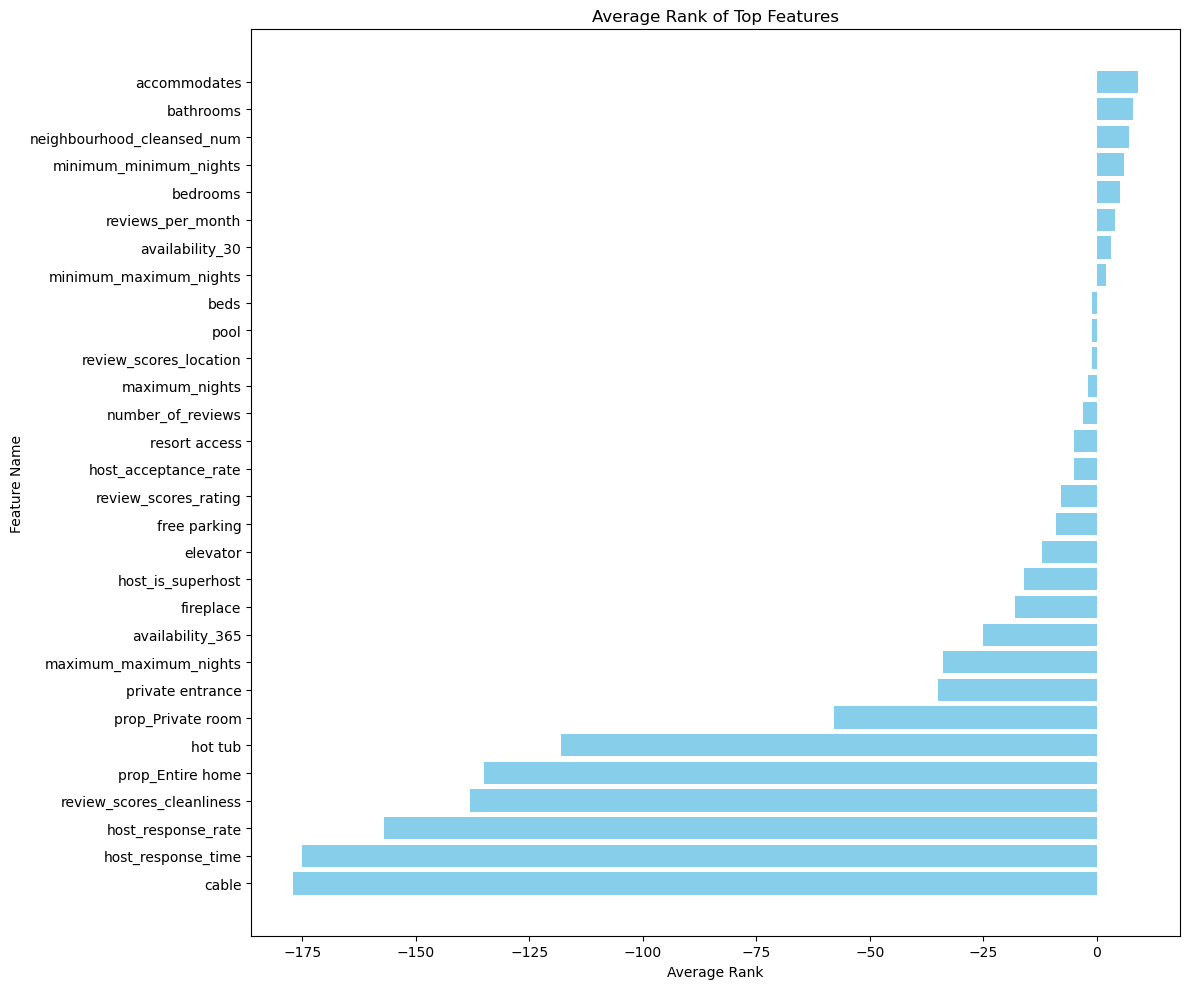

In [4]:
all_top_features = []
for _, _, sorted_features in results:
    top_20 = [feature[0] for feature in sorted_features[:20]]
    all_top_features.extend(top_20)

# Calculate the average rank for each feature
feature_ranks = {feature: 0 for feature in set(all_top_features)}
for feature in all_top_features:
    feature_ranks[feature] += (all_top_features.count(feature) - all_top_features.index(feature) - 1)

average_ranks = {feature: rank / all_top_features.count(feature) for feature, rank in feature_ranks.items()}

# Sort by average rank
sorted_avg_ranks = sorted(average_ranks.items(), key=lambda x: x[1], reverse=True)

# Displaying the sorted average ranks
for feature, rank in sorted_avg_ranks:
    print(f"{feature}: {rank}")

# Plotting the graph
features = [item[0] for item in sorted_avg_ranks]
ranks = [item[1] for item in sorted_avg_ranks]

plt.figure(figsize=(12, 10))
plt.barh(features, ranks, color='skyblue')
plt.xlabel('Average Rank')
plt.ylabel('Feature Name')
plt.title('Average Rank of Top Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()